### They are all equally spaced

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation
import os

In [2]:
save_path = r'C:\Users\Leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [3]:
########################################                 Define constants                   #############################################
N = 60
fixed_lam   = 1
fixed_gamma = 1

fixed_dist  = 0.3 * fixed_lam
fixed_phi   = 0

x_0      = 0.2
x_max    = 0.6
x_size   = 1

phi_0    = 0
phi_max  = 2 * np.pi / N
phi_size = 50

t_max    = 40
t_size   = 100
########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma
dists  = np.linspace(x_0, x_max, x_size) * fixed_lam
phis   = np.linspace(phi_0, phi_max, phi_size)

[[ 5.73219678e+02  0.00000000e+00  0.00000000e+00]
 [ 5.70079521e+02  5.99177721e+01  0.00000000e+00]
 [ 5.60693453e+02  1.19179073e+02  0.00000000e+00]
 [ 5.45164310e+02  1.77134622e+02  0.00000000e+00]
 [ 5.23662233e+02  2.33149448e+02  0.00000000e+00]
 [ 4.96422803e+02  2.86609839e+02  0.00000000e+00]
 [ 4.63744461e+02  3.36930073e+02  0.00000000e+00]
 [ 4.25985238e+02  3.83558831e+02  0.00000000e+00]
 [ 3.83558831e+02  4.25985238e+02  0.00000000e+00]
 [ 3.36930073e+02  4.63744461e+02  0.00000000e+00]
 [ 2.86609839e+02  4.96422803e+02  0.00000000e+00]
 [ 2.33149448e+02  5.23662233e+02  0.00000000e+00]
 [ 1.77134622e+02  5.45164310e+02  0.00000000e+00]
 [ 1.19179073e+02  5.60693453e+02  0.00000000e+00]
 [ 5.99177721e+01  5.70079521e+02  0.00000000e+00]
 [ 1.90920505e-13  5.73219678e+02  0.00000000e+00]
 [-5.99177721e+01  5.70079521e+02  0.00000000e+00]
 [-1.19179073e+02  5.60693453e+02  0.00000000e+00]
 [-1.77134622e+02  5.45164310e+02  0.00000000e+00]
 [-2.33149448e+02  5.23662233e+

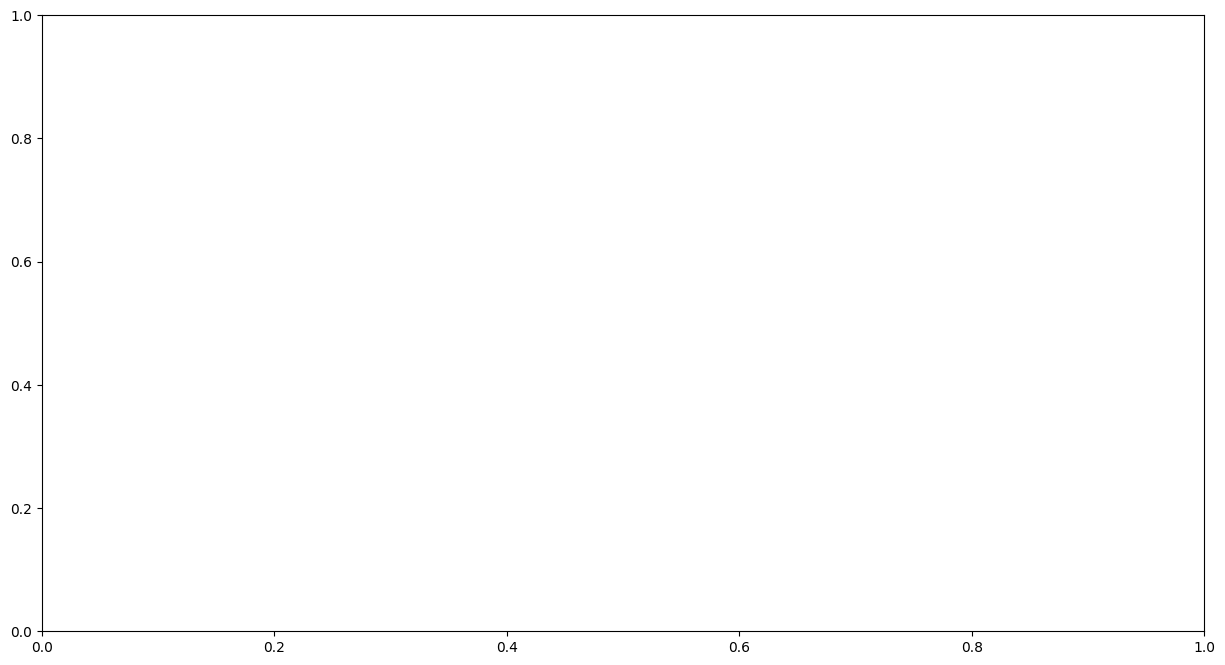

In [4]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

d_hats = np.array([dipole_vector(phi) for phi in phis])

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

def ring_positions(distance = fixed_dist, N = N):
    Pos = np.zeros((N, 3))
    mu = 2 * np.pi / N
    radius = distance / 2 / np.sin(np.pi / N)
    helper = np.array([radius, 0, 0])
    for i in range(N):
        rotation_matrix = np.linalg.matrix_power(z_rotation(mu), i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

positions = ring_positions(N)
print(positions)

# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
fig, ax = plt.subplots(figsize=(15, 8))
def update(frame):
    ax.clear()
    d_hat = d_hats[frame]
    ax.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
    ax.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
             head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
    for i, position in enumerate(positions):
        ax.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
                 head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.legend()
    ax.axis('equal')
    ax.set_title(f'Dipole vector for phi={phis[frame]:.2f}')

# Create the animation
#ani = FuncAnimation(fig, update, frames=phi_size, repeat=False)
#ani.save(save_path + f'/N={N}_dipole_vector_movement.gif', writer='pillow', fps=10)
#plt.show()

In [5]:
########################################             create the Hamiltonean                 #################################################
#jetzt direkter weg zur NxN matrix mit Greentensor
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    Greenstensor = (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))
    return Greenstensor

def Gamma_coefficients(r_a, r_b,
                       d_a = dipole_vector(), 
                       d_b = dipole_vector(),
                       lam = fixed_lam,
                       gamma = fixed_gamma) -> float:

    if np.linalg.norm(r_b - r_a) < 1e-5:
        return gamma
    k_a = 2 * np.pi / lam
    result = (6 * np.pi * gamma / k_a  # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.imag(result)

def V_coefficients(r_a, r_b,
                   d_a = dipole_vector(), 
                   d_b = dipole_vector(),
                   lam = fixed_lam,
                   gamma = fixed_gamma) -> float:
    
    if np.linalg.norm(r_b - r_a) < 1e-5:
        return 0
    k_a = 2 * np.pi / lam
    result = (-3 * np.pi * gamma / k_a # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.real(result)

def H_eff(distance = fixed_dist, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma, N=N):
    positions = ring_positions(distance, N)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]
            V_ab = V_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)

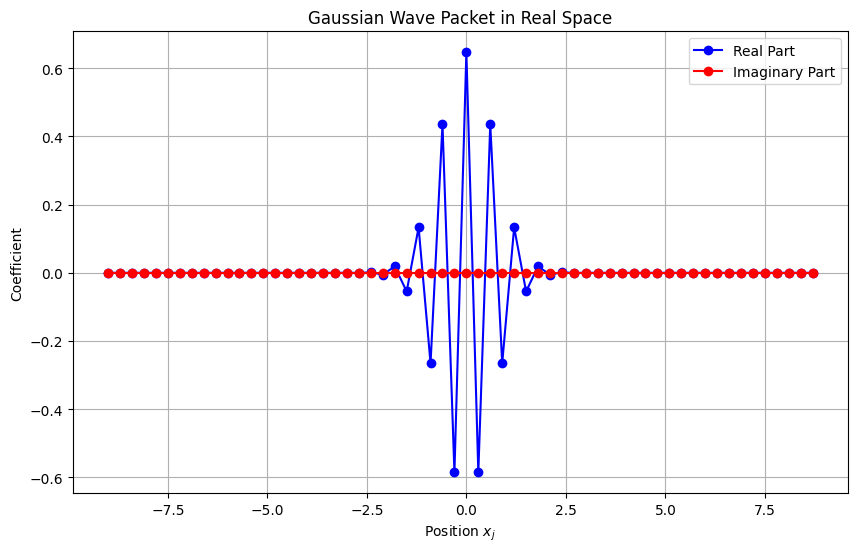

Quantum object: dims=[[60], [1]], shape=(60, 1), type='ket', dtype=Dense
Qobj data =
[[ 1.32651571e-39]
 [-4.48371591e-37]
 [ 1.24404899e-34]
 [-2.83341759e-32]
 [ 5.29733444e-30]
 [-8.12976337e-28]
 [ 1.02417017e-25]
 [-1.05910751e-23]
 [ 8.99045505e-22]
 [-6.26465282e-20]
 [ 3.58332374e-18]
 [-1.68247567e-16]
 [ 6.48463061e-15]
 [-2.05161279e-13]
 [ 5.32818454e-12]
 [-1.13589143e-10]
 [ 1.98777899e-09]
 [-2.85544023e-08]
 [ 3.36706698e-07]
 [-3.25914846e-06]
 [ 2.58958540e-05]
 [-1.68900150e-04]
 [ 9.04281279e-04]
 [-3.97420943e-03]
 [ 1.43374417e-02]
 [-4.24586601e-02]
 [ 1.03213050e-01]
 [-2.05957040e-01]
 [ 3.37359060e-01]
 [-4.53609164e-01]
 [ 5.00662389e-01]
 [-4.53609164e-01]
 [ 3.37359060e-01]
 [-2.05957040e-01]
 [ 1.03213050e-01]
 [-4.24586601e-02]
 [ 1.43374417e-02]
 [-3.97420943e-03]
 [ 9.04281279e-04]
 [-1.68900150e-04]
 [ 2.58958540e-05]
 [-3.25914846e-06]
 [ 3.36706698e-07]
 [-2.85544023e-08]
 [ 1.98777899e-09]
 [-1.13589143e-10]
 [ 5.32818454e-12]
 [-2.05161279e-13]
 [ 

In [6]:
################ TRY to get the Wave-packet
k_s = np.pi / fixed_dist
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist)
center_index = N // 2
x_j = (np.arange(N) - center_index) * fixed_dist

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()

# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
Psi_01 = (basis(N,0)-basis(N,1)).unit()
psi0

In [ ]:
from scipy.optimize import minimize
def survival_probabilities(params, times, gamma=fixed_gamma, Psi_0=basis(N, 0)):
    phis = params[:-1]
    distance = params[-1]
    
    dipoles = np.array([dipole_vector(phi) for phi in phis])
    H = H_eff(distance=distance, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    coeffs_sq_mods = np.zeros((len(times), N))
    P_surs = np.zeros((len(times)))
    
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2

        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()

    return coeffs_sq_mods, P_surs

# Define an optimization function that returns the negative of survival probability
def optimization_target(params):
    _, res = survival_probabilities(params, [times[-1]])
    return -res[0]

def positive_distance_constraint(params):
    distance = params[-1]
    return distance - 0.2 * fixed_lam   # This constraint ensures the distance remains positive

initial_phis = np.zeros(N)
mu = 2 * np.pi / N
for i in range(N):
    initial_phis[i] = i * mu + np.pi / 2
print(initial_phis)
initial_distance = 0.234 * fixed_lam  # Initial guess for the distance
initial_params = np.append(initial_phis, initial_distance)

constraints = [{'type': 'ineq', 'fun': positive_distance_constraint}]

result = minimize(optimization_target, initial_params, method='SLSQP', constraints=constraints, options={'maxiter': 1000})

optimized_params = result.x
optimized_phis = optimized_params[:-1]
optimized_distance = optimized_params[-1]

# Convert optimized phis to dipole vectors
optimized_dipoles = np.array([dipole_vector(phi) for phi in optimized_phis])

print("Optimized dipoles:")
print(optimized_dipoles)
print("Optimized distance:")
print(optimized_distance)

[1.57079633 1.67551608 1.78023584 1.88495559 1.98967535 2.0943951
 2.19911486 2.30383461 2.40855437 2.51327412 2.61799388 2.72271363
 2.82743339 2.93215314 3.0368729  3.14159265 3.24631241 3.35103216
 3.45575192 3.56047167 3.66519143 3.76991118 3.87463094 3.97935069
 4.08407045 4.1887902  4.29350996 4.39822972 4.50294947 4.60766923
 4.71238898 4.81710874 4.92182849 5.02654825 5.131268   5.23598776
 5.34070751 5.44542727 5.55014702 5.65486678 5.75958653 5.86430629
 5.96902604 6.0737458  6.17846555 6.28318531 6.38790506 6.49262482
 6.59734457 6.70206433 6.80678408 6.91150384 7.01622359 7.12094335
 7.2256631  7.33038286 7.43510261 7.53982237 7.64454212 7.74926188]


In [ ]:
y1, y2 = survival_probabilities(optimized_params, times)

In [ ]:
# Create a heatmap for state probabilities
plt.figure(figsize=(10, 6))
plt.imshow(y1.T, aspect='auto', origin='lower', cmap='Greys', extent=[0, t_max, 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()

# Plot survival probability
plt.figure(figsize=(10, 6))
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.plot(times, y2, 'b-', label='Survival Probability')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Probability over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot atoms with their dipole moments
positions = ring_positions(fixed_dist, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
optimal_dipoles = optimized_dipoles
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], optimized_dipoles[i][0] * scale, optimized_dipoles[i][1] * scale, head_width=0.5 * scale, head_length=0.5 * scale, fc='red', ec='red')

plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

In [47]:
def norms_cal(times: np.array,
              distance = fixed_dist,
              gamma    = fixed_gamma,
              d_a = dipole_vector(), 
              d_b = dipole_vector(),
              Psi_0    = basis(N, 0)):
    '''          works for NxN ^ matrices            #              lam = fixed_lam, add as input?
    Calculate the probability of transitioning from an initial state to a final state     over a given time, given the parameters of the Hamiltonian.    '''
    H = H_eff(distance=distance, d_a=d_a, d_b=d_b, lam = fixed_lam, gamma=gamma, N=N)
    all_norms = []
    for t in times:
        U = (-1j * H * t).expm()
        Psi_t = U * Psi_0
        norm_sq = Psi_t.norm()**2
        all_norms.append(norm_sq)
    return np.array(all_norms)

#
# Animation
#

def Norms(times: np.array,
          distances = np.array([fixed_dist]),
          d_hats    = np.array([dipole_vector()]),
          Psi_0     = basis(N, 0),
          animate_dist = False, animate_dipole = False): # only one at a time
    ''' works for NxN   ^ matrices ohne den gamma anteil '''    
    norms = np.zeros((len(distances), len(d_hats), len(times)), dtype=float)
    filename_prefix = ''
    
    if animate_dist:
        for c_idx, dist in enumerate(tqdm(distances, desc='Coefficients')):
            for d_idx, d_hat in enumerate(d_hats):
                norms[c_idx, d_idx, :] = norms_cal(times, distance=dist, d_a=d_hat, d_b=d_hat, Psi_0=Psi_0)
        for d_idx, d_hat in enumerate(d_hats):
            filename_prefix = f'Ps_g={gamma:.2f}_dipole=[{d_hat[0]:.2f},{d_hat[1]:.2f}]'
            DIST_ani(norms[:, d_idx, :], filename_prefix, distances)
        
    if animate_dipole:
        for d_idx, d_hat in enumerate(tqdm(d_hats, desc='Dipoles')):
            for c_idx, dist in enumerate(distances):
                norms[g_idx, c_idx, d_idx, :] = norms_cal(times, distance=dist, d_a=d_hat, d_b=d_hat, Psi_0=Psi_0)
        for c_idx, dist in enumerate(dists):
            filename_prefix = f'Ps_g={gamma:.2f}_dipole=[{d_hat[0]:.2f},{d_hat[1]:.2f}]'
            DIPOLE_ani(norms[c_idx, :, :], filename_prefix, d_hats)


    return norms, filename_prefix

def DIST_ani(data, filename_prefix, distances):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    def update(frame):
        ax.clear()
        ax.set_title(f'Distance = {distances[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Distance = {distances[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()
    
    ani = FuncAnimation(fig, update, frames=len(distances), interval=200)
    ani.save(save_path + f'\DistDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)

def DIPOLE_ani(data, filename_prefix, dipoles):
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        ax.set_title(f'Dipole = {dipoles[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Dipole = {dipoles[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()

    ani = FuncAnimation(fig, update, frames=len(dipoles), interval=200)
    ani.save(save_path + f'\DipoleDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)

In [8]:
#############################################---------        calculations           ---------###########################################################

[0.007036068568531932]
[0.005854424733519445]
[0.0018699527415709015]
[0.010792067264138991]
[0.0202499460777692]
[0.04799881200626982]
[0.009393969362664198]
[0.019826613185736537]
[0.02370127894892458]
[0.0007326146477958564]
[7.108913414673925e-05]
[0.01659167197978853]
[0.03278148660116874]
[0.014857402793277595]
[0.0017360099480213849]
[0.0028983448240704848]
[0.010640866081015613]
[0.007460030072383598]
[0.02778531130775768]
[0.008182048382237524]
[0.0058709367384950605]
[0.0070556937703727535]
[0.03788964064493618]
[0.003375328342993552]
[0.013713080498695617]
[0.016580923663915635]
[0.006455348010730994]
[0.00012248564530842112]
[0.008651285338146249]
[0.013100190654042816]
[0.029460453862360125]
[0.0031163183005569355]
[0.0025927624067559997]
[0.026684593603424487]
[0.0033940448705266513]
[0.0024510603900304746]
[0.05152226401128281]
[0.00020214480142698673]
[0.0015371180775466458]
[0.01103297397559684]
[0.05032634763943675]
[0.024167998945347918]
[0.0018707290806030115]
[0.00

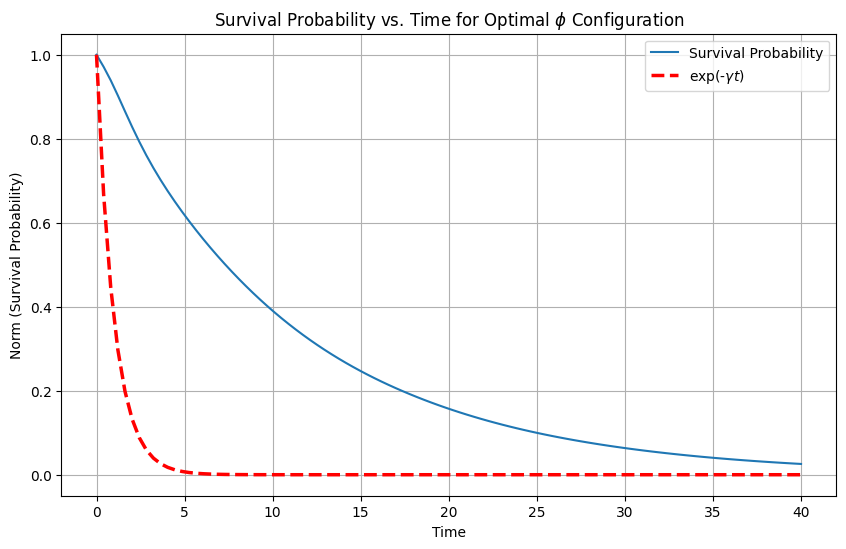

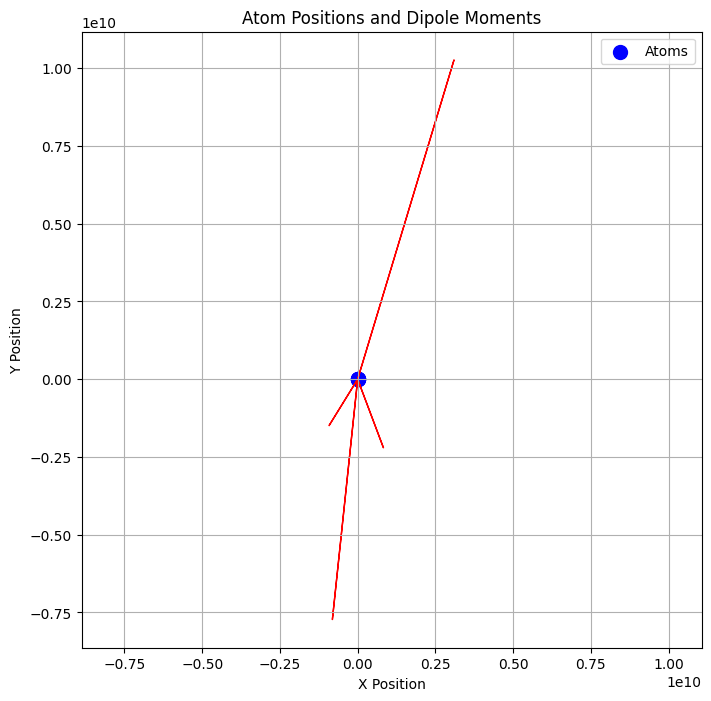

In [33]:
# calculate the optimal phi configuration
from scipy.optimize import differential_evolution
def H_eff(distance = fixed_dist, dipoles = None, lam=fixed_lam, gamma=fixed_gamma, N=N):
    positions = ring_positions(distance, N)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]
            V_ab = V_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)

def norms_cal(times, distance = fixed_dist, gamma=fixed_gamma, dipoles=None, Psi_0=basis(N, 0)):
    H = H_eff(distance = distance, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    all_norms = []
    for t in times:
        U = (-1j * H * t).expm()
        Psi_t = U * Psi_0
        norm_sq = Psi_t.norm()**2
        all_norms.append(norm_sq)
    print(all_norms)
    return np.array(all_norms)

# Define the cost function to be minimized (negative of the survival probability at t=10*gamma)
def cost_function(phis):
    dipoles = [dipole_vector(phi) for phi in phis]
    survival_probabilities = norms_cal([10 * fixed_gamma], dipoles=dipoles, Psi_0=psi0)
    survival_probability = survival_probabilities[0]
    return -survival_probability

# Define the bounds for each phi value
bounds = [(0, 2 * np.pi) for _ in range(N)]

result = differential_evolution(cost_function, bounds)
optimal_phis = result.x
optimal_survival_probability = -result.fun

print(f"Optimal phis: {optimal_phis}")
print(f"Optimal survival probability: {optimal_survival_probability}")

optimal_dipoles = np.array([dipole_vector(phi) for phi in optimal_phis]).flatten()

# Calculate norms over the entire time range
def survival_probability(dipoles, times, Psi_0, distance=fixed_dist, lam=fixed_lam, gamma=fixed_gamma, N=N):
    dipoles = dipoles.reshape((N, 3))
    H = H_eff(distance, dipoles, lam, gamma, N)
    U = (-1j * H * times[len(times) // 2]).expm()
    Psi_t = U * Psi_0
    norm_sq = (Psi_t.norm())**2
    return norm_sq
norms = []
for time in times:
    norm = survival_probability(optimal_dipoles, [time], psi0)
    norms.append(norm)

## Calculate norms over the entire time range
#norms = norms_cal(times, dipoles=optimal_dipoles)

# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, norms, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Optimal $\phi$ Configuration')
plt.legend()
plt.grid(True)
plt.show()
# Plot atoms with their dipole moments
positions = ring_positions(fixed_dist, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
optimal_dipoles = optimal_dipoles_flat.reshape((N, 3))
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], optimal_dipoles[i][0] * scale, optimal_dipoles[i][1] * scale, head_width=0.5 * scale, head_length=0.5 * scale, fc='red', ec='red')

plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
# only plot one dipole rotating
def norms_cal_1dipole_rotating(times: np.array, distance=fixed_dist, d_hats=np.array([dipole_vector()]), Psi_0=basis(N, 0)):
    norms = np.zeros((len(d_hats), len(times)), dtype=float)

    for d_idx, d_hat in enumerate(d_hats):
        norms[d_idx, :] = norms_cal(times, distance=distance, gamma=gamma, d_a=dipole_vector(), d_b=d_hat, Psi_0=Psi_0)
    return norms
def plot_1_dip(norms, times, dist = fixed_dist):
    fig, ax = plt.subplots(figsize=(10, 6))
    for d_idx, d_hat in enumerate(d_hats):
        ax.plot(times, norms[d_idx, :], label=f'd_hat=[{d_hat[0]:.1f}, {d_hat[1]:.1f}]')
    ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
    ax.set_title(f'distance={dist:.2f}, gamma = 1')
    ax.set_xlabel('Time t')
    ax.set_ylabel(r'$P_{sur}$')
    ax.legend()
#    plt.savefig(save_path + f'/.testpng')
    plt.show()
# calculate everything
def norms_cal_everything(times: np.array, distances=np.array([fixed_dist]), d_hats=np.array([dipole_vector()]), Psi_0=basis(N, 0)):
    norms = np.zeros((len(distances), len(d_hats), len(times)), dtype=float)

    for c_idx, dist in enumerate(tqdm(distances, desc='Coefficients')):
        for d_idx, d_hat in enumerate(d_hats):
            norms[c_idx, d_idx, :] = norms_cal(times, distance=dist, gamma=gamma, d_a=d_hat, d_b=d_hat, Psi_0=Psi_0)
    return norms

def plot_all(norms, times, distances):
    fig, ax = plt.subplots(figsize=(10, 6))
    for c_idx, dist in enumerate(distances):
        for d_idx, d_hat in enumerate(d_hats):
                ax.plot(times, norms[c_idx, d_idx, :], label=f'd={dist}, d_hat=[{d_hat[0]:.1f}, {d_hat[1]:.1f}]')
    ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
    ax.set_title('gamma = 1')
    ax.set_xlabel('Time t')
    ax.set_ylabel(r'$P_{sur}$')
    ax.legend()
#    plt.savefig(save_path + f'/.testpng')
    plt.show()


#norms = norms_cal_everything(times, distances=dists, d_hats=d_hats, Psi_0=psi0)
#plot_all(norms, times, dists)

norms_1_dip = norms_cal_1dipole_rotating(times, d_hats=d_hats, Psi_0=psi0)
plot_1_dip(norms_1_dip, times)
#TODO


In [113]:
# TODO
#dist_norms   = Norms(times, distances=dists, d_hats=d_hats, animate_dist=True,Psi_0=psi0)  # Distance animation
#dipole_norms = Norms(times, d_hats=d_hats, animate_dipole=True)  # Dipole animation
#gamma_norms  = Norms(times, gammas=gammas, animate_gamma=True)  # Gamma animation

## Investigate the Phase # this makes no sense for the ring, just for the correct  topology 

In [ ]:
def total_phases(distances, phis):
    total_ps = np.zeros((len(phis), len(distances)))
    for i, phi in enumerate(tqdm(phis, desc='Iteration')):
        for j, distance in enumerate(distances):
            H = H_eff(N, distance, dipole_vector(phi))
            p = (np.angle(H[0, 1]) + np.angle(H[0, 2]) +np.angle(H[1, 2])) / np.pi
            total_ps[i, j] = p
    return total_ps

phases = total_phases(dists, phis)

In [ ]:
# plot phi(distances for many dipole orientation)
fig, ax = plt.subplots(figsize=(8, 6))
def init():
    ax.set_title('Phase of off-diagonal entries of H over distance')
    return []
def update(frame):
    ax.clear()
    phi = phis[frame]
    ax.plot(dists, phases[frame, :], label=r'total Phase/ $\pi$')
    ax.set_xlabel(r'distance x')
    ax.set_ylabel(r'Phase / $\pi$')
    ax.set_title(f'Phase of off-diagonal entries of H over distance for $\phi$={phi:.2f}')
    ax.legend()
    return []

ani = FuncAnimation(fig, update, frames=len(phis), init_func=init, blit=True, repeat=False)

# Save the animation as a single GIF file
ani.save('phase_animation_distance.gif', writer='pillow', fps=10)

plt.show()

In [ ]:
#H_eff(N, distance: float = fixed_dist, d_hat: np.array = dipole_vector(), gamma: float = fixed_gamma)
# Extract the phase of the off-diagonal elements. this code only makes sense for symmetric distances
# H_12 = V_12 - i / 2 G_12 == R * exp(i phi(x))
# also for H_13, H_23
# plot phi(dipole orientation for many distances)
fig, ax = plt.subplots(figsize=(8, 6))

def init():
    ax.set_title('Phase of off-diagonal entries of H over $\phi$')
    ax.grid(True)
    ax.axis('equal')
    return []

def update(frame):
    ax.clear()
    x_value = dists[frame]
    ax.plot(phis, phases[:, frame], label=r'total Phase/ $\pi$')
    ax.set_xlabel(r'Angle $\phi$')
    ax.set_ylabel(r'Phase / $\pi$')
    ax.set_title(f'Phase of off-diagonal entries of H over $\phi$ for x={x_value:.2f}')
    ax.legend()
    return []

ani = FuncAnimation(fig, update, frames=len(dists), init_func=init, blit=True, repeat=False)

# Save the animation as a single GIF file
ani.save('phase_animation_phi.gif', writer='ffmpeg', fps=10)

plt.show()

## old implementation

In [ ]:
#####################################             old and complicated definition of H_eff                 ###########################################
def ladder_operator(i: int, N: int, operator_type):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op
def single_excitation_basis(N: int):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states
def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()
def H_eff(N: int,
          distance: float = fixed_dist, 
          d_hat: np.array = dipole_vector(),
          gamma: float = fixed_gamma):
    pos = ring_positions(N, distance)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, N, 'raising')
            lowering_op_j = ladder_operator(j+1, N, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma
def H_eff_red(N: int,
              distance: float = fixed_dist, 
              d_hat: np.array = dipole_vector(),
              gamma: float = fixed_gamma):

    H = H_eff(N, distance, d_hat, gamma)
    single_exc_basis = single_excitation_basis(N)
    H_reduced = np.zeros((N, N), dtype=complex)

    for i, bra in enumerate(single_exc_basis):
        for j, ket in enumerate(single_exc_basis):
            H_reduced[i, j] = H.matrix_element(bra.dag(), ket)

    return Qobj(H_reduced)
# example form of the Hamiltonean
H_red_ex = H_eff_red(N)
H_red_ex
def ring_positions(N: int, distance: float = 1):
    """Returns the positions of the N atoms in a 2D shape."""
    # Start with an initial guess for x
    x = distance / (2 * np.sin(np.pi / N))

    # Define a function to calculate the distance between adjacent atoms
    def calculate_distances(x):
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
        adjusted_angles = angles + np.pi / N
        x_coords = np.cos(adjusted_angles) * x
        y_coords = np.sin(adjusted_angles) * x
        pos = np.column_stack((x_coords, y_coords))
        distances = np.linalg.norm(np.diff(np.vstack((pos, pos[0])), axis=0), axis=1)
        return distances

    # Use an iterative approach to adjust x until the desired distance condition is met
    def optimize_x(x):
        distances = calculate_distances(x)
        return np.abs(np.mean(distances) - distance)

    # Use scipy.optimize to find the optimal value of x
    from scipy.optimize import minimize
    result = minimize(optimize_x, x, method='Nelder-Mead')

    if result.success:
        x = result.x[0]
    else:
        raise ValueError("Optimization failed.")

    # Calculate the final positions using the optimized x
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    adjusted_angles = angles + np.pi / N
    x_coords = np.cos(adjusted_angles) * x
    y_coords = np.sin(adjusted_angles) * x
    pos = np.column_stack((x_coords, y_coords))

    return pos
positions = ring_positions(N)
print(positions)



def H_eff(N: int,
          distance: float = fixed_dist, 
          d_hat: np.array = dipole_vector(),
          gamma: float = fixed_gamma):

    H_eff_matrix = np.zeros((N, N), dtype=complex)
    pos = ring_positions(distance, N)

    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))

            matrix_element = V_ij - 1j * 0.5 * Gamma_ij
            H_eff_matrix[i, j] = matrix_element
            
    return Qobj(H_eff_matrix)
H_ex = H_eff(N)
H_ex


def Norms(times: np.array,
          distances = np.array([fixed_dist]),
          gammas    = np.array([fixed_gamma]),
          d_hats    = np.array([dipole_vector()]),
          Psi_0     = basis(N, 0),
          animate_dist = False, animate_dipole = False, animate_gamma = False): # only one at a time
    ''' works for NxN   ^ matrices '''    
    norms = np.zeros((len(gammas), len(distances), len(d_hats), len(times)), dtype=float)
    filename_prefix = ''
    
    if animate_dist:
        for c_idx, dist in enumerate(tqdm(distances, desc='Coefficients')):
            for d_idx, d_hat in enumerate(d_hats):
                for g_idx, gamma in enumerate(gammas):
                    norms[g_idx, c_idx, d_idx, :] = norms_cal(times, distance=dist, gamma=gamma, d_hat=d_hat, Psi_0=Psi_0)

        for g_idx, gamma in enumerate(gammas):
            for d_idx, d_hat in enumerate(d_hats):
                filename_prefix = f'Ps_g={gamma:.2f}_dipole=[{d_hat[0]:.2f},{d_hat[1]:.2f}]'
                DIST_ani(norms[g_idx, :, d_idx, :], filename_prefix, distances)
        
    if animate_dipole:
        for d_idx, d_hat in enumerate(tqdm(d_hats, desc='Dipoles')):
            for c_idx, dist in enumerate(distances):
                for g_idx, gamma in enumerate(gammas):
                    norms[g_idx, c_idx, d_idx, :] = norms_cal(times, distance=dist, gamma=gamma, d_hat=d_hat, Psi_0=Psi_0)
    
    if animate_gamma:
        for g_idx, gamma in enumerate(tqdm(gammas, desc='Gammas')):
            for d_idx, d_hat in enumerate(d_hats):
                for c_idx, dist in enumerate(distances):
                    norms[g_idx, c_idx, d_idx, :] = norms_cal(times, distance=dist, gamma=gamma, d_hat=d_hat, Psi_0=Psi_0)

    return norms, filename_prefix
    
#            progress_bar = tqdm(times, desc=f"Calculating norms for d_hat index={i}, x={x:.2f}", unit="timestep", leave=False)
            


def DIST_ani(data, filename_prefix, distances):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    def update(frame):
        ax.clear()
        ax.set_title(f'Distance = {distances[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Distance = {distances[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()
    
    ani = FuncAnimation(fig, update, frames=len(distances), interval=200)
    ani.save(save_path + f'\DistDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)

def DIPOLE_ani(data, filename_prefix, dipoles):
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        ax.set_title(f'Dipole = {dipoles[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Dipole = {dipoles[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()

    ani = FuncAnimation(fig, update, frames=len(dipoles), interval=200)
    ani.save(save_path + f'\DipoleDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)

def GAMMA_ani(data, filename_prefix, gammas):
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        ax.set_title(f'Gamma = {gammas[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Gamma = {gammas[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()

    ani = FuncAnimation(fig, update, frames=len(gammas), interval=200)
    ani.save(save_path + f'\GammaDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)
#g_0      = 0.05
#g_max    = 1
#g_size   = 1
#gammas = np.linspace(g_0, g_max, x_size)